<a href="https://colab.research.google.com/github/ruben9324/curso-series-temporales/blob/master/03_Ruben_Antuna_Herrero_TextClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://github.com/luisgasco/ntic_master_datos/raw/main/datasets/fake_news_2_classification.csv
import nltk
import sys  
!{sys.executable} -m pip install contractions
!pip install spacy==3.2.1
!python -m spacy download en_core_web_sm
nltk.download('punkt')
nltk.download('stopwords')

--2022-05-28 15:25:21--  https://github.com/luisgasco/ntic_master_datos/raw/main/datasets/fake_news_2_classification.csv
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/luisgasco/ntic_master_datos/main/datasets/fake_news_2_classification.csv [following]
--2022-05-28 15:25:22--  https://raw.githubusercontent.com/luisgasco/ntic_master_datos/main/datasets/fake_news_2_classification.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3867470 (3.7M) [text/plain]
Saving to: ‘fake_news_2_classification.csv’

fake_news_2_classif 100%[===================>]   3.69M  --.-KB/s    in 0.07s   

2022-05-28 15:

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.9 MB 5.2 MB/s 
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 2.2.5
    Uninstalling en-core-web-sm-2.2.5:
      Successfully uninstalled en-core-web-sm-2.2.5
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
def visualizar_k_rows_df(df, numero_filas, cmap):
  return df.head(numero_filas).style.background_gradient(cmap = cmap)

# Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string 
import re 
import contractions 
from tqdm.autonotebook import tqdm
tqdm.pandas()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


# Cargar y preparar los datos


En primer lugar, cargaremos la base de datos descarga anteriormente con titulares de noticias falsas y noticias verdaderas

In [5]:
# Leemos el dataset con read_csv y separador "\t", fake_news_2_classification.csv
dataset = pd.read_csv("fake_news_2_classification.csv", sep = "\t")

In [9]:
visualizar_k_rows_df(dataset.sample(40),3,'RdBu_r')

,title,fake
7157,plans to cart water to capella,0
58128,Comments of the Week: Here Comes Trouble,1
17935,img boss dies,0


# Análisis exploratorio de los datos (EDA)




En este apartado pretendemos realizar un análisis de los datos previo a la normalización de los mismos. Este análisis nos va a permitir extraer información relevante del dataset, así como posibles inconvenientes que serán solucionados llegado el caso.


* **Número de documentos y columnas:**

Comenzamos mostrando el número de documentos, o lo que es lo mismo, el número de filas del data frame:

In [12]:
print("Tenemos un conjunto de {} documentos".format(len(dataset)))
print("El dataframe tiene {} columnas".format(dataset.shape[1]))

Tenemos un conjunto de 59601 documentos
El dataframe tiene 2 columnas


* **Número de documentos duplicados:**

Despues, comprobamos y eliminamos las filas con algún valor vacío (NA) y quitaremos los duplicados.

In [16]:
# metodo duplicated con subset=["title"]
print("Existen {} noticias duplicadas".format(np.sum(dataset.duplicated(subset=["title"]))))


Existen 30 noticias duplicadas


In [17]:
# Quitaremos esos duplicados
dataset = dataset.drop_duplicates()
print("Despues de quitar duplicados tenemos un conjunto de {} noticias".format(dataset.shape[0]))

Despues de quitar duplicados tenemos un conjunto de 59571 noticias


Comprobaramos que no hayan quedado Nulls en ningunas de las dos columnas del dataset

In [18]:
print("Hay {} valores vacíos en las noticias y {} valores vacíos en las etiquetas en los datos".format(np.sum(dataset.isnull())[0],
                                                                                                        np.sum(dataset.isnull())[1]))

Hay 0 valores vacíos en las noticias y 0 valores vacíos en las etiquetas en los datos


* **Número de documentos por cada clase:**

Contamos el número de elementos de cada clase, esto se hace muy fácil con un groupby de la columna 'positive' y un conteo posterior. También se puede hacer con un value_counts sobre la serie de la etiqueta.

In [20]:
print(dataset["fake"].value_counts())


0    30000
1    29571
Name: fake, dtype: int64


In [ ]:
# Número de elementos de cada clase:
dataset.groupby(['fake']).count()

¡¡Tenemos un dataset balanceado!! Esto nos evitará problemas en el entrenamiento de los modelos😀. 

Disponemos 30000 noticias verdaderas (valor 0) y 29571 noticias falsas (valor 1).

Vamos a dibujar un histograma con las clases así practicamos:

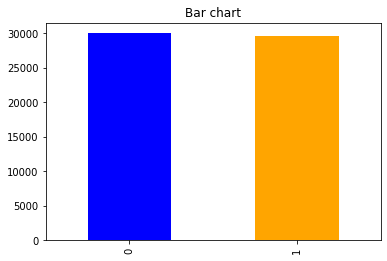

In [21]:
ax, fig = plt.subplots()
etiquetas = dataset.fake.value_counts()
etiquetas.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Bar chart')
plt.show()

* **Distribución de la longitud de los tweet en caracteres:**

Para seguir con el análisis exploratorio, vamos a hacer un cálculo típico: la longitud de cada uno de los textos de los documentos para despues dibujar su histograma. 

Comenzamos creando las columnas que van a almacenar las longitud en caracteres y en tokens de los documentos del corpus:

In [23]:
dataset["char_len"] = dataset["title"].apply(lambda x:len(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


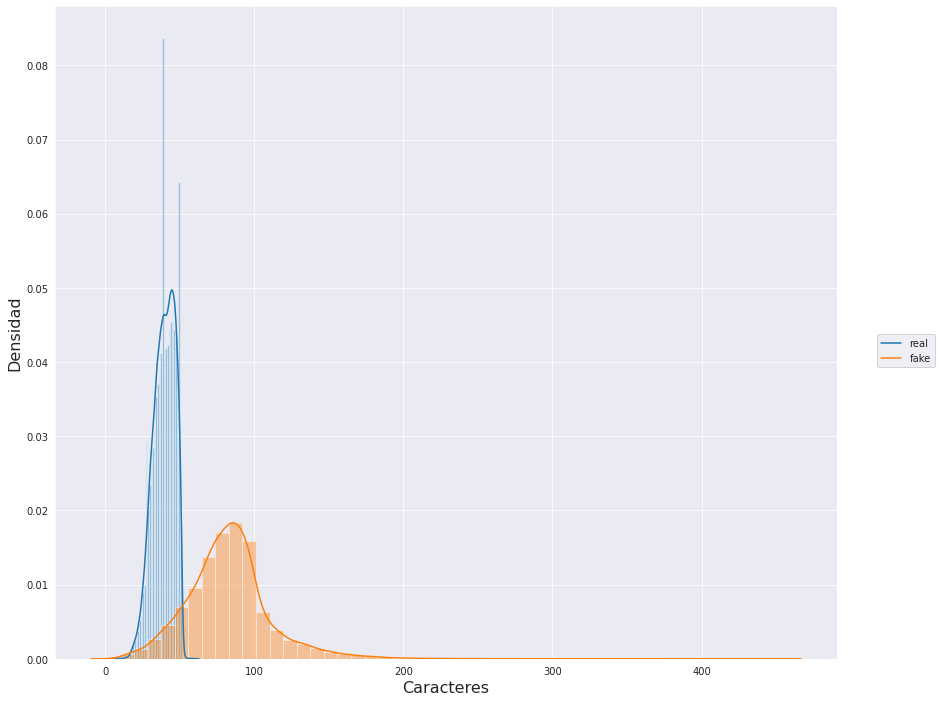

In [24]:
# Importamos las librerías matplotlib y seaborn:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(14,12))
sns.set_style("darkgrid")
# añadimos series para cada categoría (eligiendo la seríe de char_len
plt1 = sns.distplot(dataset[dataset.fake==0].char_len, hist=True, label="real")
plt2 = sns.distplot(dataset[dataset.fake==1].char_len, hist=True, label="fake")
fig.legend(labels=['real','fake'], loc = 5)


# Definimos el título de los ejes:
plt.xlabel('Caracteres', fontsize=16)
plt.ylabel('Densidad', fontsize=16)

# Finalmente mostramos el gráfico:
plt.show()


Una noticia interesante! Vemos que las distribuciones de longitud de los titulares cambian en función de la veracidad de la noticia. La longitud de las noticias falsas suelen tener una logitud mayor. 
Esto es un dato muy interesante, viendo la separación de estas variables podríamos entrenar un "clasificador" que funcionara bastante bien con la regla `if len(noticia)>50 "fake" else "verdad"`


# Transformación
Como hemos visto, está dividido en dos pasos Normalización o Preprocesado y Transformación

## Normalización
Vamos a proceder a normalizar los datos. Para ello vamos a generar pequeñas funciones que nos permitan:
- Eliminar espacios extra.
- Transformar a minúsculas.
- Tokenizar.
- Reemplazar contractions.
- Lematizar tokens.
- Eliminar stopwords.
- Eliminar sígnos de puntuación.

In [25]:
# Eliminar espacios
def eliminar_espacios(text): 
    return  " ".join(text.split()) 

# To lower
def texto_to_lower(text):
  return text.lower()

# Tokenizador
from nltk import word_tokenize
def tokenization(text):
  tokens = word_tokenize(text)
  return tokens

# Reemplazar contractions usando la librería "contractions" https://github.com/kootenpv/contractions
def replace_contraction(text):
    expanded_words = []
    for t in text.split():
        expanded_words.append(contractions.fix(t))
    expanded_text = ' '.join(expanded_words) 
    return expanded_text

# Quitar stop words
from nltk.corpus import stopwords
def quitar_stopwords(tokens):
    stop_words = set(stopwords.words('english')) 
    filtered_sentence = [w for w in tokens if not w in stop_words]
    return filtered_sentence


# Eliminar signos de puntuación (nos quedamos sólo lo alfanumérico en este caso)
def quitar_puntuacion(tokens):
    words=[word for word in tokens if word.isalnum()]
    return words


# Lemmatization
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
def lematizar(tokens):
    sentence = " ".join(tokens)
    mytokens = nlp(sentence)
    # Lematizamos los tokens y los convertimos  a minusculas
    mytokens = [ word.lemma_ if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    # Extraemos el text en una string
    return mytokens


import string
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
def stem(tokens):
    tokens = [ stemmer.stem(token) for token in tokens]
    return tokens


Posteriormente podríamos crear una función que preprocesara los textos según nuestras necesidades:


In [26]:
def preprocesado_fakenews(sentence, remove_spaces =True)
  if (remove_spaces):
    sentence = eliminar_espacios(x)
  sentence = texto_to_lower(sentence)
 ......

SyntaxError: ignored

Podríamos generar una función de transformación que aglutinara todas las anteriores y pasársela al siguiente paso (TfidfVectorizer) en el campo analyzer. Para ver el proceso de cada uno de los pasos lo haremos paso a paso:



In [27]:
# Quitar Espacios
dataset["normaliza"] = dataset["title"].progress_apply(lambda x: eliminar_espacios(x))
# To Lower
dataset["normaliza"] = dataset["normaliza"].progress_apply(lambda x: texto_to_lower(x))
# Contraciones
dataset["normaliza"] = dataset["normaliza"].progress_apply(lambda x: replace_contraction(x))
# Tokenizar
dataset["normaliza"] = dataset["normaliza"].progress_apply(lambda x: tokenization(x))
# Quitar Stopwords
dataset["normaliza"] = dataset["normaliza"].progress_apply(lambda x: quitar_stopwords(x))
# Quitar puntuación
dataset["normaliza"] = dataset["normaliza"].progress_apply(lambda x: quitar_puntuacion(x))
# Stemming
dataset["normaliza"] = dataset["normaliza"].progress_apply(lambda x: stem(x))
# Mirar todo lo que tarda con lematización (mediante spacy)
#dataset["normaliza"] = dataset["normaliza"].progress_apply(lambda x: lematizar(x))

dataset["normaliza"]



  0%|          | 0/59571 [00:00<?, ?it/s]

  0%|          | 0/59571 [00:00<?, ?it/s]

  0%|          | 0/59571 [00:00<?, ?it/s]

  0%|          | 0/59571 [00:00<?, ?it/s]

  0%|          | 0/59571 [00:00<?, ?it/s]

  0%|          | 0/59571 [00:00<?, ?it/s]

  0%|          | 0/59571 [00:00<?, ?it/s]

0                  [aba, decid, commun, broadcast, licenc]
1                      [act, fire, wit, must, awar, defam]
2                [g, call, infrastructur, protect, summit]
3                [air, nz, staff, aust, strike, pay, rise]
4            [air, nz, strike, affect, australian, travel]
                               ...                        
59596                          [stock, crude, crumbl, low]
59597    [tesla, earn, smash, expect, dramat, chang, re...
59598                   [rule, ruler, world, realli, work]
59599    [caught, tape, isi, destroy, iraqi, abram, mis...
59600    [obamacar, architect, admit, law, work, design...
Name: normaliza, Length: 59571, dtype: object

Como explicamos ayer, se ha hecho el preprocesado, y antes de introducirlo a TFIDF vamos a generar una frase de gada una de las listas de tokens, para utilizar el propio tokenizador de TFIDF.

In [28]:
dataset["clean_text"] = dataset["normaliza"].progress_apply(lambda x: " ".join(x))

  0%|          | 0/59571 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


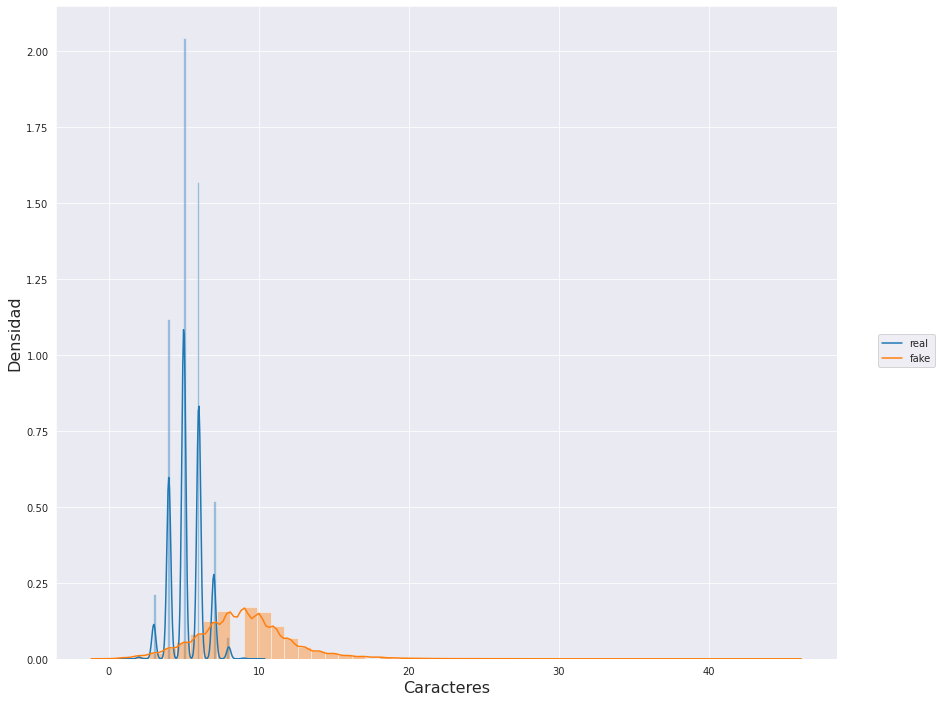

In [29]:
dataset["token_len"] = dataset["normaliza"].apply(lambda x: len(x))

fig = plt.figure(figsize=(14,12))
sns.set_style("darkgrid")
plt1 = sns.distplot(dataset[dataset.fake==0].token_len, hist=True, label="real")
plt2 = sns.distplot(dataset[dataset.fake==1].token_len, hist=True, label="fake")
fig.legend(labels=['real','fake'],loc=5)

# Definimos el título de los ejes:
plt.xlabel('Caracteres', fontsize=16)
plt.ylabel('Densidad', fontsize=16)

plt.show()

## Vectorizacion


Queremos que la funcionalidad 'TfidfVectorizer' tenga en cuenta los siguientes aspectos:

- Pocas características (30 en total) para evitar overfitting
- Considerar unigramas, bigramas y trigramas
- Que el sistema no considere los elementos que salgan en menos del 1% de los documentos.
- No considerar procesados ya hechos (lowercase y stopwords) 

In [32]:
vectorizador = TfidfVectorizer(max_features=30,
                               ngram_range=(1,3),
                               min_df=0.01,
                               lowercase=False)

vector_data = vectorizador.fit_transform(dataset["clean_text"])

# Entrenar/validar el clasificador:

Entramos ya en el apartado de entrenamiento del modelo. El primer paso es definir las variables predictoras, que son las características extraidas anteriormente a través de TF-IDF. 

También especificaremos cual es la variable con las clases de cada documento.


In [33]:
# Importamos numpy:
import numpy as np

# Definimos la variable de categorías:
y = dataset["fake"].values.astype(np.float32) 

print(y.shape)

(59571,)


In [34]:
vector_data

<59571x30 sparse matrix of type '<class 'numpy.float64'>'
	with 52181 stored elements in Compressed Sparse Row format>

Tenemos 30 características para 52k documentos.

En primer lugar, dividamos el dataset en Train/Test:

In [35]:
X_train, X_test, y_train, y_test = train_test_split(vector_data, y , random_state=0)
print(X_train.shape)
print(X_test.shape)

(44678, 30)
(14893, 30)


**Decision de modelo de ML a utilizar**

En primer lugar se ha generado una función para medir la calidad de varios modelos estándar de forma fácil y ver sus resultados. 

La función hace un KFold y evalua diferentes modelos con una métrica de evblauación:

In [37]:
# Definimos las funcionalidades pertinentes de sklearn:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings 
# Definimos la función encargada de evaluar los modelos:
def model_evaluation(models, score, X, y):
      results = []
      names = []
      #PAra cada modelo
      for name, model in models:
          warnings.filterwarnings('ignore') 
          # Generamos un Kfold
          KF = KFold(n_splits = 8, shuffle = True, random_state = 98)

          # hacemos croos_val
          cv_results = cross_val_score(model, X, y, cv = KF, scoring = score, verbose = False)
          
          # Guardamos los resultados:
          results.append(cv_results)
          names.append(name)
          
          # Mostramos los resultados numéricamente:
          print('Metric: {} , KFold '.format(str(score)))
          print("%s: %f (%f) " % (name, cv_results.mean(), cv_results.std()))

      return results, names

Una vez definida la función, podemos definir los modelos con los que hacer la evaluación. En este caso hemos incorporado la regresión logística y una naive bayes. 

In [38]:
# Cargamos los modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# Definimos los modelos y generamos una lista con cada uno de ellos:
models = [
         ("Logistic",LogisticRegression(random_state= 30)), # Logistic ¡Regression
         ("GaussianNB",GaussianNB())
]

evaluation_score = "accuracy"

model_evaluation(models,  evaluation_score, vector_data.toarray(), y)   

Metric: accuracy , KFold 
Logistic: 0.802941 (0.002825) 
Metric: accuracy , KFold 
GaussianNB: 0.801413 (0.002203) 


([array([0.80354505, 0.80448503, 0.79978515, 0.80445877, 0.80821918,
         0.80325007, 0.80096696, 0.79881816]),
  array([0.8016651 , 0.80354505, 0.79897945, 0.80298147, 0.80499597,
         0.80136986, 0.79922106, 0.79854956])],
 ['Logistic', 'GaussianNB'])

Observamos un mejor funcionamiento con el regresor logístico, que será con el que intentaremos afinar los hiperparámetros:

In [39]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]


Vamos a generar un diccionario para la búsqueda Grid y también generaremos el objeto GridSearchCV. Vamos a utilizar una métrica de búsqueda basada en accuracy (por probar)

In [40]:
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = KFold(n_splits=8)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

Entrenamos el modelo y hacemos un "print" del mejor resultado:

In [41]:
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Mejor accuracy: %f usando los parámetros %s" % (grid_result.best_score_, grid_result.best_params_))


Mejor accuracy: 0.803057 usando los parámetros {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}


Tenemos modelo! Los resultados mejores deben ser introducidos a un modelo específico para ser entrenado:

In [42]:
from sklearn.model_selection import (KFold, cross_val_score,cross_validate)
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

model=LogisticRegression(C=1, penalty = "l2", solver="newton-cg")
model.fit(X_train,y_train)


LogisticRegression(C=1, solver='newton-cg')

Predecimos el set de test

In [43]:
y_pred = model.predict(X_test)


Creamos una matriz de confusión y un "classification report".

In [44]:

from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[7290  158]
 [2780 4665]]
              precision    recall  f1-score   support

         0.0       0.72      0.98      0.83      7448
         1.0       0.97      0.63      0.76      7445

    accuracy                           0.80     14893
   macro avg       0.85      0.80      0.80     14893
weighted avg       0.85      0.80      0.80     14893



Además podemos pintar esa matriz de confusión para tener los resultados más "bonitos".

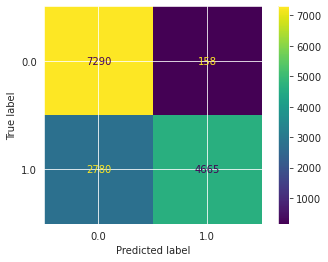

In [45]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, X_test, y_test, normalize = None)

Si quisieramos aplicar el modelo a nuevos datos, tendríamos que preprocesarlo del mismo modo que a los datos de entrenamiento y deberíamos transformarlo con el TFIDFVectorizar anteriormente entrenado. Despues de eso ya se podría incorporar sin problemas al `model.predict(Xnew)`